### Import Packages

In [1]:
! nvidia-smi

Fri Jul 18 18:08:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   24C    P0             30W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, GlobalAveragePooling1D, Masking
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


### Data Preprocessing

In [3]:
wind_cols = ['uSq','e_uSq','n_uSq','Z2','Z3','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df = pd.read_csv('WLIS_data.csv')
df = df.rename(columns={'WSPD':'u', 'Fetch':'Z3'})
df['TmStamp'] = pd.to_datetime(df['TmStamp'], format='mixed')
df.set_index('TmStamp', inplace=True)

# Add squared terms (uSq)
df['uSq'] = df['u']**2

# Add east and north components (e_uSq, n_uSq)
alpha = -13
df['rad'] = np.pi/180 * ((alpha + 630 - df['WDIR']) % 360)
df['e_uSq'] = df['uSq'] * np.cos(df['rad'])
df['n_uSq'] = df['uSq'] * np.sin(df['rad'])

# Add interaction terms (Z2, Z4)
df['Z2'] = np.sqrt(df['Z3']) * df['u']
df['Z4'] = (df['Z3']**1.5) / df['u']

# Train-Test split
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df[(df.index < split1) | (df.index > split2)]
df_test = df[(df.index > split1) & (df.index < split2)]

# Data normalization
scaled_wave, scaled_wind = MinMaxScaler(), MinMaxScaler()
df_train, df_test = df_train.copy(), df_test.copy()
df_train.loc[:, 'scaled_H'] = scaled_wave.fit_transform(df_train[['H']])
df_test.loc[:, 'scaled_H'] = scaled_wave.transform(df_test[['H']])
df_train.loc[:, scaled_wind_cols] = scaled_wind.fit_transform(df_train[wind_cols])
df_test.loc[:, scaled_wind_cols] = scaled_wind.transform(df_test[wind_cols])

### Data Preparation: Train-Test-Validation Split

In [4]:
step, output = 24, 12
features = ['scaled_H'] + scaled_wind_cols

def create_sequences(df, step, output):
    X, y = [], []
    periods = step + output
    for i in range(len(df) - periods + 1):
        window = df.iloc[i:(i+periods)]
        expect = pd.date_range(start=window.index[0], periods=periods, freq='h')
        if not window.index.equals(expect):
            continue
        ## Case 1 & 2 & 3 & 4
        # X_seq = window.iloc[:step, 1:].values
        ## Case 5
        X_seq = window.values.copy()
        X_seq[step:, 0] = -1
        y_seq = window.iloc[step:, 0].values
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]
df_train = df_train[(df_train.index < split1) | (df_train.index > split3)]

X_train, y_train = create_sequences(df_train[features], step, output)
X_val, y_val = create_sequences(df_val[features], step, output)
X_test, y_test = create_sequences(df_test[features], step, output)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(105739, 36, 7) (105739, 12)
(8725, 36, 7) (8725, 12)
(8749, 36, 7) (8749, 12)


### Model Selection and Implementation

I0000 00:00:1753287381.700413 2645949 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Epoch 1/100


I0000 00:00:1753287385.259384 2646186 cuda_dnn.cc:529] Loaded cuDNN version 90300


1653/1653 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 3/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 7/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/100
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 9/100
1653/1653 ━━━━━━━━━━━━━━

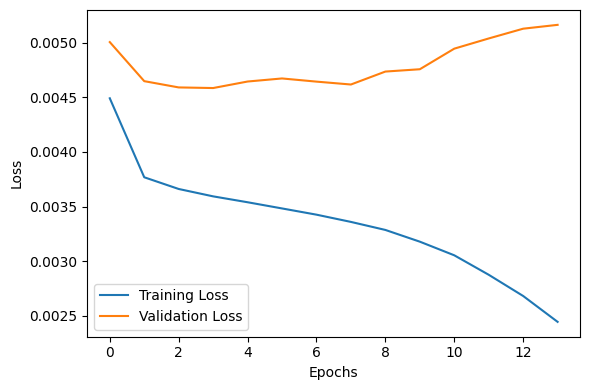

In [ ]:
epochs = 100
batch_size = 64
model_file = 'model_5_1.keras'

def create_model(X_train):
    # Input layer with shape: (batch_size, time_steps, features)
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Masking layer
    mask_layer = Masking(-1)(input_layer)

    # LSTM layer
    units = 256
    lstm_layer = LSTM(units=256, activation='tanh', return_sequences=True)(mask_layer)
    lstm_out = LSTM(units=units, activation='tanh', return_sequences=True)(lstm_layer)
    
    # Attention layer
    num_heads = 2
    attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=units//num_heads)
    attn_out, attn_scores = attn_layer(lstm_out, lstm_out, return_attention_scores=True)
    
    # Pooling layer
    pooled_out = GlobalAveragePooling1D()(attn_out)

    # Output layer
    output_layer = Dense(12, activation='relu')(pooled_out)
    
    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mse'])
    attn_model = Model(inputs=input_layer, outputs=attn_scores)
    
    return model, attn_model

# Train and save the model (architecture + weights)
model, attn_model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

- **Time steps**: 6
- **Batch size**: 64
- **# of LSTM layers**: 1, 2, 3, 4
- **# of LSTM units**: 16, 32, 64, 128, 256
- **# of Attention heads**: 2, 4, 8
- **Activation**: 'tanh' (might work better for LSTM layers)
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

In [5]:
%run hp_tuning.py

Reloading Tuner from hp_tuning/model_case3/tuner0.json


In [6]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)
print()

# Best model
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(optimizer=Adam(learning_rate=best_hp.values['learning_rate']), loss='mse', metrics=['mse'])
print(best_model.summary())

# Extract attention weights
attn_layer = best_model.get_layer("multihead_attn")
attn_model = Model(inputs=best_model.input, outputs=attn_layer.output[1])

{'layers': 3, 'units_0': 128, 'heads': 8, 'learning_rate': 0.0014091897562814942, 'units_1': 32, 'units_2': 256, 'units_3': 16, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}



I0000 00:00:1752854284.859216 1194856 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:e3:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 128)   │     69,632 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 12, 32)    │     20,608 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 12, 256)   │    295,936 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ [(None, 12, 256), │    263,168 │ lstm_2[0][0],     │
│ (MultiHeadAttentio… │ (None, 8, 12,     │            │ lstm_2[0][0]      │
│                     │ 12)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multihead_attn[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │      1,542 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 650,886 (2.48 MB)

 Trainable params: 650,886 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1752854302.459583 1196288 cuda_dnn.cc:529] Loaded cuDNN version 90300


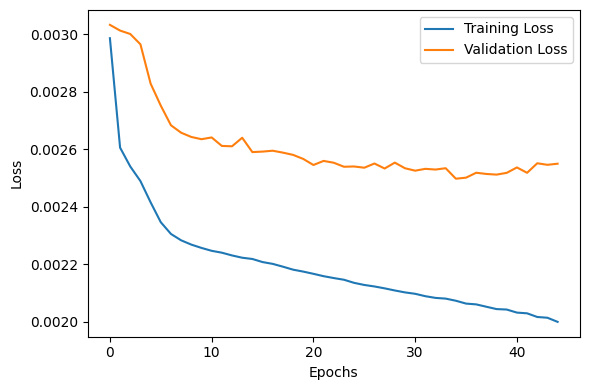

In [7]:
model_file = 'best_model.keras'

# Train and save the model (architecture + weights)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

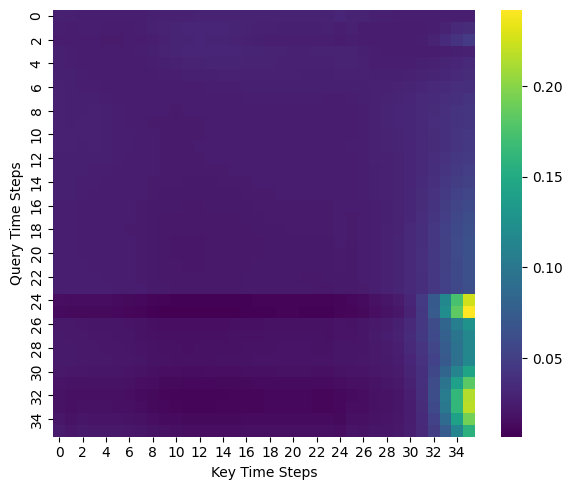

In [6]:
head_idx = 0
attn_weights = attn_model.predict(X_test, verbose=0)
attn_head_matrix = attn_weights[:, head_idx, :, :]
attn_matrix = np.mean(attn_head_matrix, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix, cmap='viridis')
plt.xlabel("Key Time Steps")
plt.ylabel("Query Time Steps")

plt.tight_layout()
plt.show()

### Model Evaluation

In [5]:
constant = 0

# Define uncertainty levels for future hours
uncertainty = np.linspace(1.5, 3.0, 12)

if constant:
    X_test[:, step:, -6:] = X_test[:, step-1:step, -6:]
else:
    for i in range(output):
        X_wind = scaled_wind.inverse_transform(X_test[:, step+i, -6:])
        X_noise = X_wind.copy()
        WSPD = np.sqrt(X_noise[:, 0])
        WSPD += np.random.normal(loc=0.0, scale=uncertainty[i])
        WSPD_noise =  np.clip(WSPD, 0.25, None)

        X_noise[:, 0] = np.square(WSPD_noise)                        # uSq
        X_noise[:, 1] = X_wind[:, 1] / X_wind[:, 0] * X_noise[:, 0]  # e_uSq
        X_noise[:, 2] = X_wind[:, 2] / X_wind[:, 0] * X_noise[:, 0]  # n_uSq
        X_noise[:, 3] = X_wind[:, 3] / WSPD * WSPD_noise             # Z2
        X_noise[:, 5] = X_wind[:, 5] * WSPD / WSPD_noise             # Z4

        X_noise_df = pd.DataFrame(X_noise, columns=wind_cols)
        X_test[:, step+i, -6:] = scaled_wind.transform(X_noise_df)

In [6]:
model_file = 'model_3_3.keras'

In [7]:
def rolling_forecast(model, X, step, output=12):
    X_c = X.copy()
    preds = []
    for i in range(output):
        pred = model.predict(X_c, verbose=0)
        preds.append(pred[:, 0])
        if X.shape[1] < step + output:
            X_c = np.concatenate([X_c[:, 1:, :], X_c[:, -1:, :]], axis=1)
            X_c[:, -1, 0] = pred[:, 0]
        else:
            X_c[:, step+i, 0] = pred[:, 0]
    return np.stack(preds, axis=1)

# Load the saved model
model = load_model(model_file)

# Training error
# y_pred1 = rolling_forecast(model, X_train, step=step, output=output)
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = scaled_wave.inverse_transform(y_pred1)
y_true1 = scaled_wave.inverse_transform(y_train)
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1_raw)):.3f}')
rmse_array1 = np.sqrt(mean_squared_error(y_true1, y_pred1_raw, multioutput='raw_values'))
print('Training RMSE per output:', ', '.join([f'{rmse:.3f}' for rmse in rmse_array1]))

# Validation error
# y_pred2 = rolling_forecast(model, X_val, step=step, output=output)
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = scaled_wave.inverse_transform(y_pred2)
y_true2 = scaled_wave.inverse_transform(y_val)
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2_raw)):.3f}')
rmse_array2 = np.sqrt(mean_squared_error(y_true2, y_pred2_raw, multioutput='raw_values'))
print('Validation RMSE per output:', ', '.join([f'{rmse:.3f}' for rmse in rmse_array2]))

# Test error
# y_pred3 = rolling_forecast(model, X_test, step=step, output=output)
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = scaled_wave.inverse_transform(y_pred3)
y_true3 = scaled_wave.inverse_transform(y_test)
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')
rmse_array3 = np.sqrt(mean_squared_error(y_true3, y_pred3_raw, multioutput='raw_values'))
print('Test RMSE per output:', ', '.join([f'{rmse:.3f}' for rmse in rmse_array3]))

I0000 00:00:1753293441.511677 2688410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
I0000 00:00:1753293443.545821 2688957 cuda_dnn.cc:529] Loaded cuDNN version 90300


Training RMSE: 0.438
Training RMSE per output: 0.319, 0.354, 0.392, 0.408, 0.422, 0.438, 0.455, 0.466, 0.476, 0.483, 0.490, 0.507
Validation RMSE: 0.548
Validation RMSE per output: 0.309, 0.379, 0.435, 0.482, 0.523, 0.557, 0.578, 0.604, 0.617, 0.640, 0.656, 0.665
Test RMSE: 0.279
Test RMSE per output: 0.188, 0.247, 0.326, 0.294, 0.266, 0.266, 0.336, 0.328, 0.268, 0.245, 0.264, 0.281


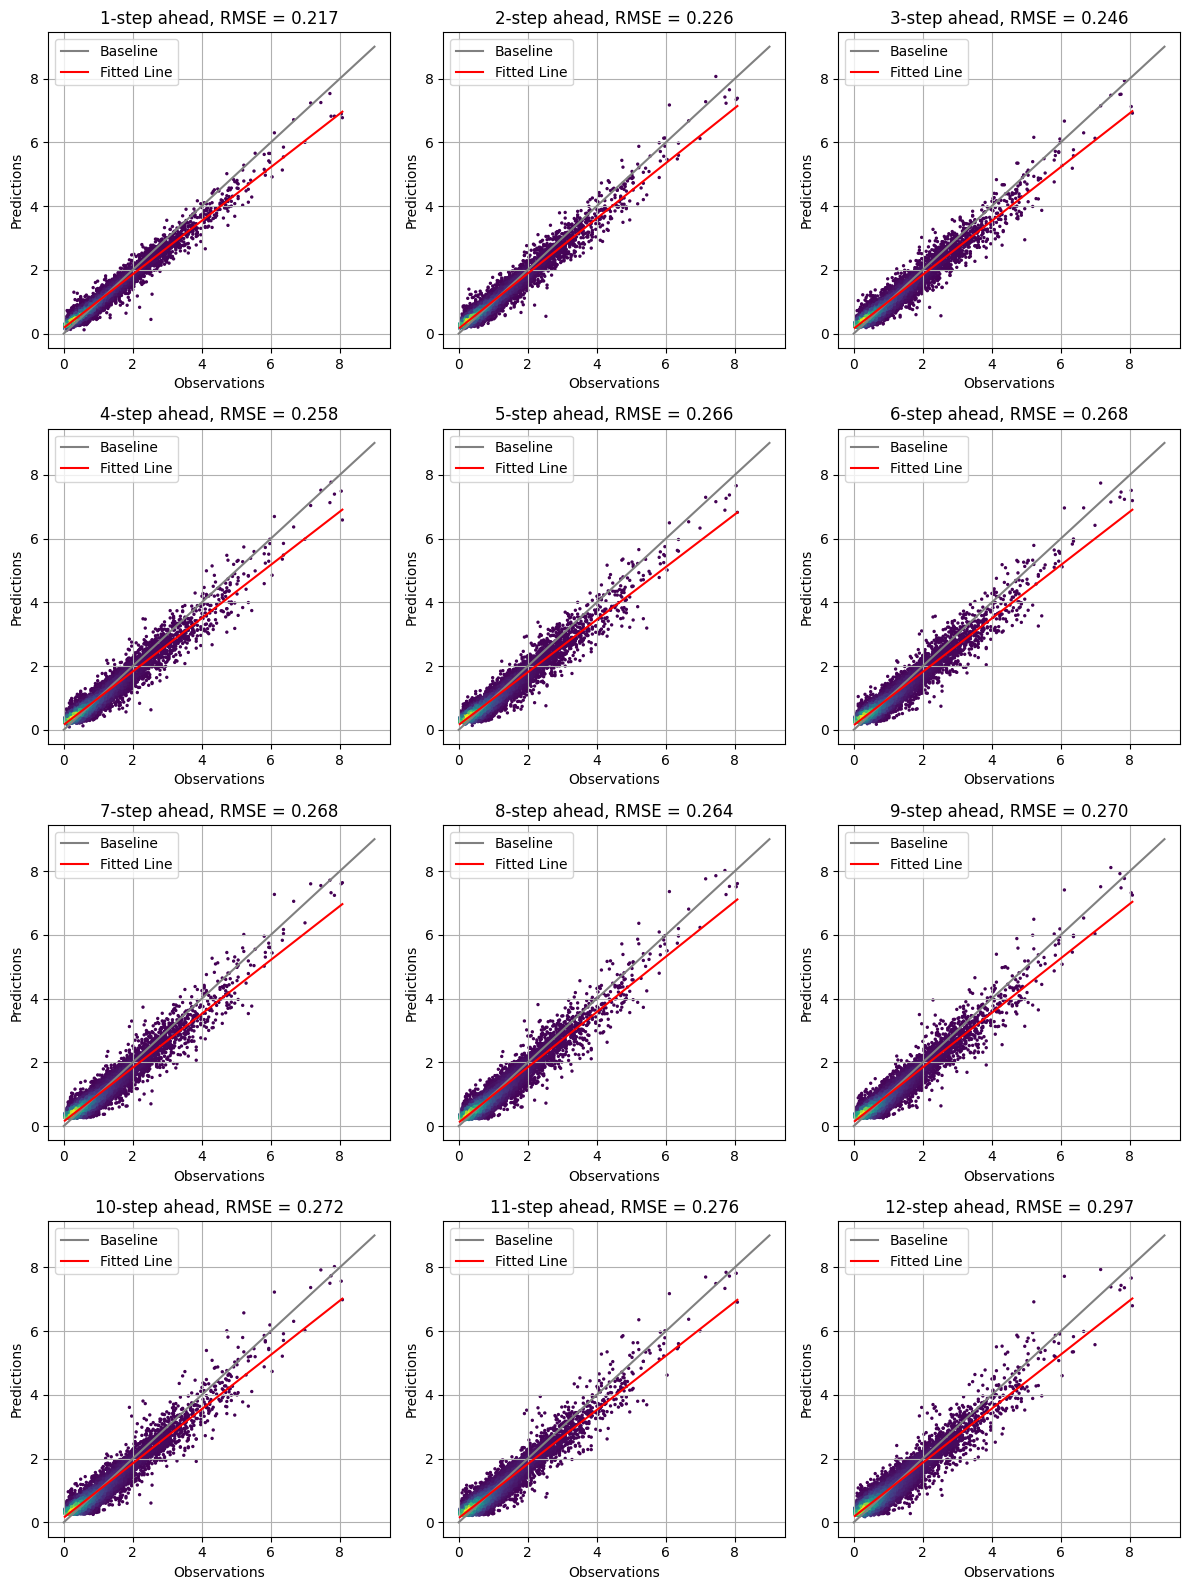

In [8]:
def pred_vs_obs(y_true, y_pred, rmse_array):
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        yt, yp = y_true[:,i], y_pred[:,i].flatten()

        ax.plot([0, 9], [0, 9], color='grey', label='Baseline')
        ax.plot(np.unique(yt), np.poly1d(np.polyfit(yt, yp, 1))(np.unique(yt)), color='r', label='Fitted Line')
        kernel = stats.gaussian_kde(np.vstack([yt, yp]))(np.vstack([yt, yp]))
        ax.scatter(yt, yp, c=kernel, s=2, cmap='viridis')

        ax.set_title(f'{i+1}-step ahead, RMSE = {rmse_array[i]:.3f}')
        ax.set(xlabel='Observations', ylabel='Predictions')
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw, rmse_array3)

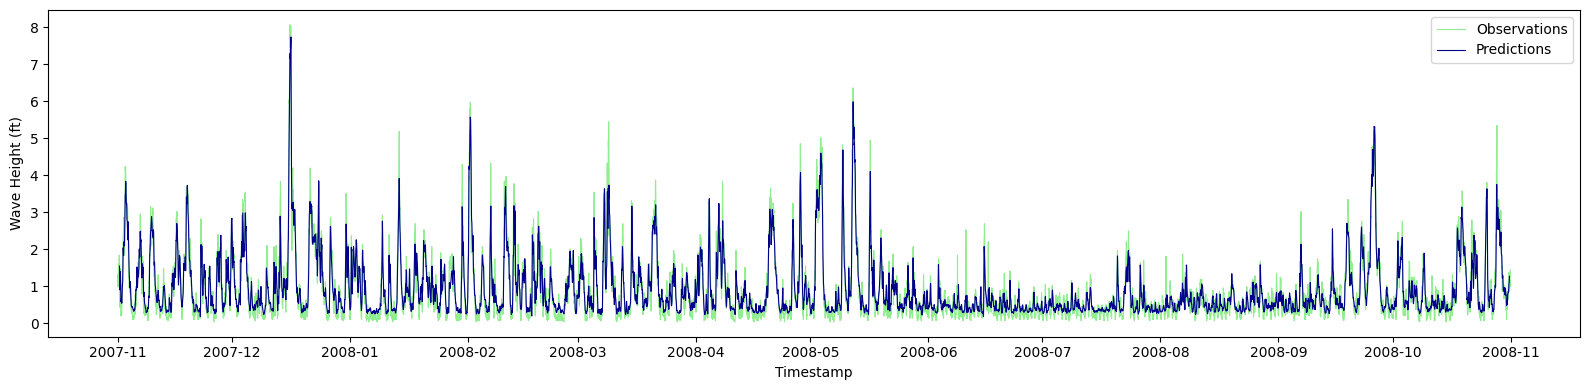

In [9]:
idx = 5
start = step + idx
end = len(df_test) - (output - idx - 1)

plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['H'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index[start:end], y_pred3_raw[:, idx], linewidth=0.8, color='darkblue', label='Predictions')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()